In [1]:
import os, sys, shutil
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import torch
sys.path.insert(0, '../utils')
import loss_funcs, eval_utils
import importlib

Notebook to explore and demonstrate segmentation loss terms

In [2]:
'''
Pull examples of model segmentations
'''
importlib.reload(eval_utils)
ms = ['WNetX_1Ba', 'WNetM_1A', 'WNetMfn_1F', 'WNetM_1B', 'WNetM_1E', 'WNetMfn_3A', 'WNetM_1A_again', # good sampling of "bad" segs
      'WNetX_1B', 'WNetX_2Ba', 'WNetM_1D', 'TrNetXfn_1A', 'WNetXfn_3A', 'WNetMfn_2A', 'WNetX_3B', 
      'WNetTfn_2C', 'WNetTfn_1D', 'WNetVfn_2A', 'WNetVfn_1A', 'WNetX_3A', 'WNetMfn_1Fa', 'WNetT_1B', 
      'WNetTfn_1A', 'WNetMfn_1G', 'WNetXfn_1Ba', 'WNetMfn_2Ba', 'WNetX_2B', 'TrNetXfn_2A']
examples = []
for m in ms:
    path = f'../../model_runs_seg/MURaM/{m}/test_preds_MURaM'
    pred_files = [f for f in os.listdir(path) if 'pred' in f]
    example_map = np.load(f'{path}/{pred_files[np.random.randint(0,len(pred_files))]}')
    example_pred = eval_utils.map_to_onehot(example_map)
    examples.append(example_pred) # convert back to original 
pickle.dump(examples, open('example_segmentations.pkl','wb'))

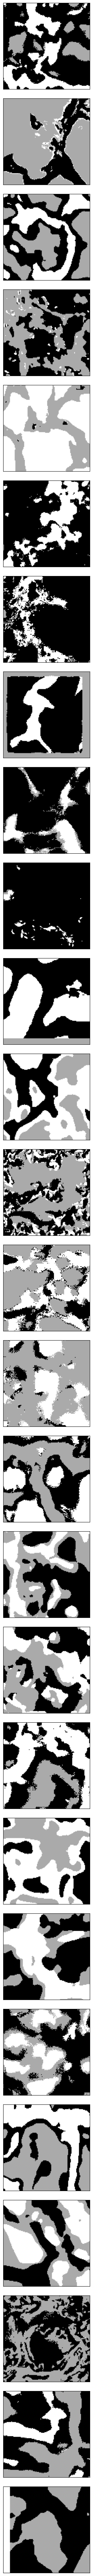

In [3]:
examples = pickle.load(open('example_segmentations.pkl','rb'))
fig, axs = plt.subplots(len(examples), 1, figsize=(3*1, 3*len(examples)))
for i in range(len(examples)):
    axs[i].imshow(eval_utils.onehot_to_map(examples[i]), cmap='gist_gray') # ; axs[i].set_ylabel(ms[i])
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)

/tmp/ipykernel_2458282/2375411633.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


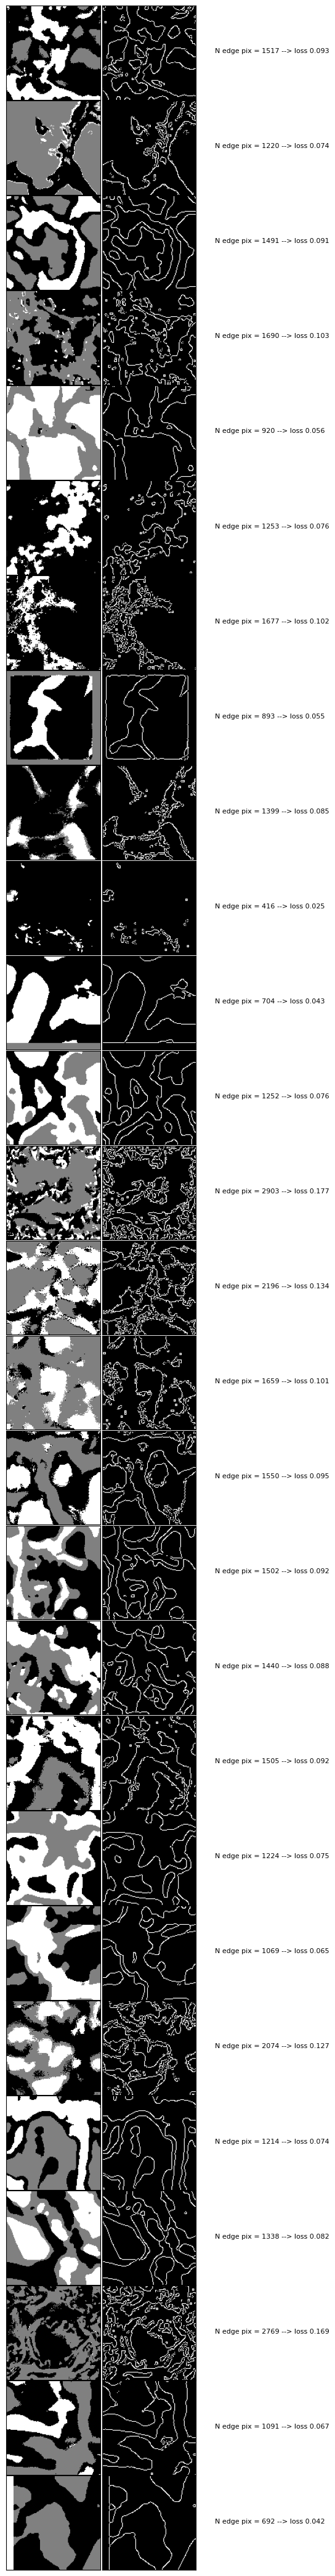

In [4]:
'''
"Cohesian loss"
'''
examples = pickle.load(open('example_segmentations.pkl','rb'))
fig, axs = plt.subplots(len(examples), 2, figsize=(2*2, 2*len(examples)))
for i in range(len(examples)):
    pred = np.argmax(examples[i], axis=0) 
    axs[i,0].imshow(pred, cmap='gist_gray')
    cv2.imwrite(f"temp_img.png", pred) 
    edges = np.array(cv2.Canny(cv2.imread('temp_img.png'),0,1.5))
    edge_pix = len(edges[edges > 0])
    axs[i,1].imshow(edges, cmap='gist_gray')
    loss = edge_pix/(pred.shape[0]**2)
    plt.text(1.2, 0.5, f'N edge pix = {edge_pix} --> loss {np.round(loss,3)}', fontsize=8, transform=axs[i,1].transAxes)
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)


/tmp/ipykernel_3171184/1810603329.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


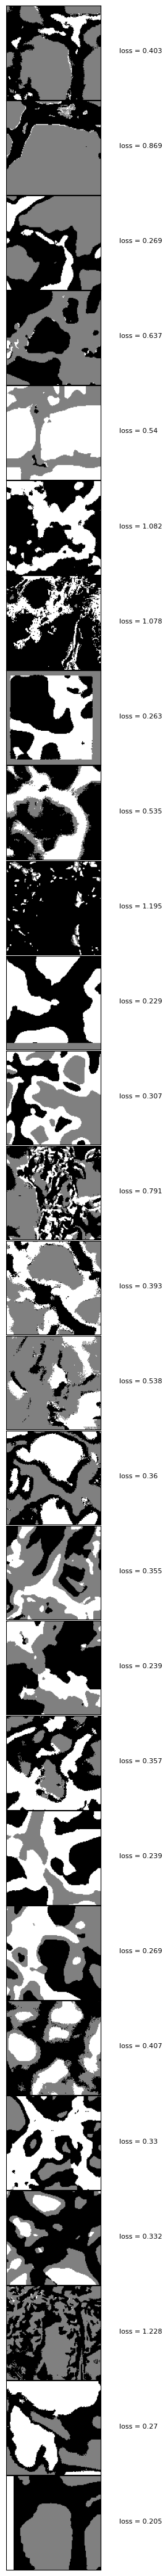

In [11]:
'''
"Soft N-Cut Loss"
'''
importlib.reload(loss_funcs)
fig, axs = plt.subplots(len(examples), 1, figsize=(2*1, 2*len(examples)))
for i in range(len(examples)):
    pred = examples[i]
    axs[i].imshow(np.argmax(examples[i], axis=0), cmap='gist_gray')
    weights = loss_funcs.calculate_weights(np.expand_dims(pred, 0), batch_size=1, img_size=(128,128))
    ls = []
    k = pred.shape[0]
    for j in range(0, k):
        l = loss_funcs.soft_n_cut_loss_single_k(weights, np.expand_dims(pred[(j,), :, :],0), batch_size=1, img_size=(128,128))
        ls.append(l) 
    da = torch.stack(ls)
    loss = torch.mean(k - torch.sum(da, dim=0))
    plt.text(1.2, 0.5, f'loss = {np.round(loss,3)}', fontsize=8, transform=axs[i].transAxes)
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)

/tmp/ipykernel_3171184/3122875402.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


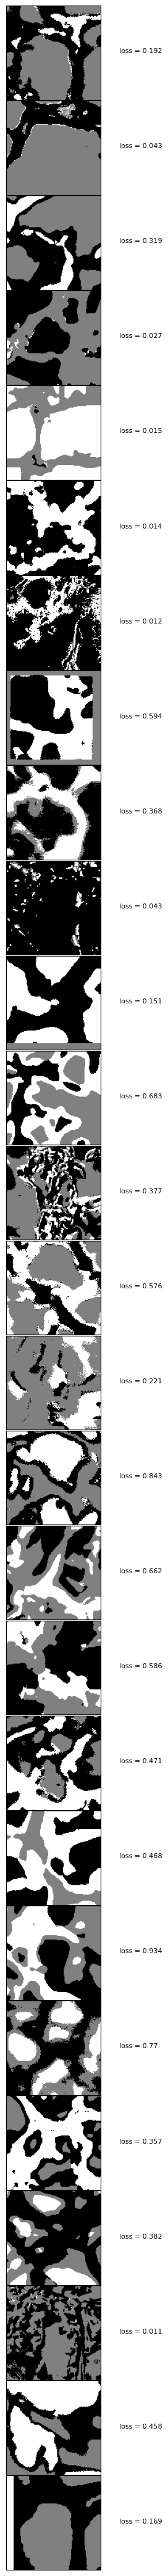

In [13]:
'''
"class size loss"
'''
importlib.reload(loss_funcs)
fig, axs = plt.subplots(len(examples), 1, figsize=(2*1, 2*len(examples)))
for i in range(len(examples)):
    pred = examples[i]
    axs[i].imshow(np.argmax(examples[i], axis=0), cmap='gist_gray')
    N0 = np.sum(pred[0,:,:])
    N1 = np.sum(pred[1,:,:])
    N2 = np.sum(pred[2,:,:])
    N_low = np.min([N0, N1, N2])# number in the smallest class
    N_high = np.max([N0, N1, N2]) # number in the largest class
    N_mid = [N for N in [N0, N1, N2] if N not in [N_low, N_high]][0]
    loss = N_low/np.mean([N_mid, N_high]) # should be << 1
    plt.text(1.2, 0.5, f'loss = {np.round(loss,3)}', fontsize=8, transform=axs[i].transAxes)
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)

regions  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
reg_sizes [126, 8893, 1, 3, 172, 1, 84, 393, 5619, 4, 1, 1, 1, 274, 2, 58, 1, 588, 122, 40]
reg_classes  [0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0]
classes  [0 1 2]
reg_per_class  [1, 3, 16]


/tmp/ipykernel_3171184/3123942453.py:43: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


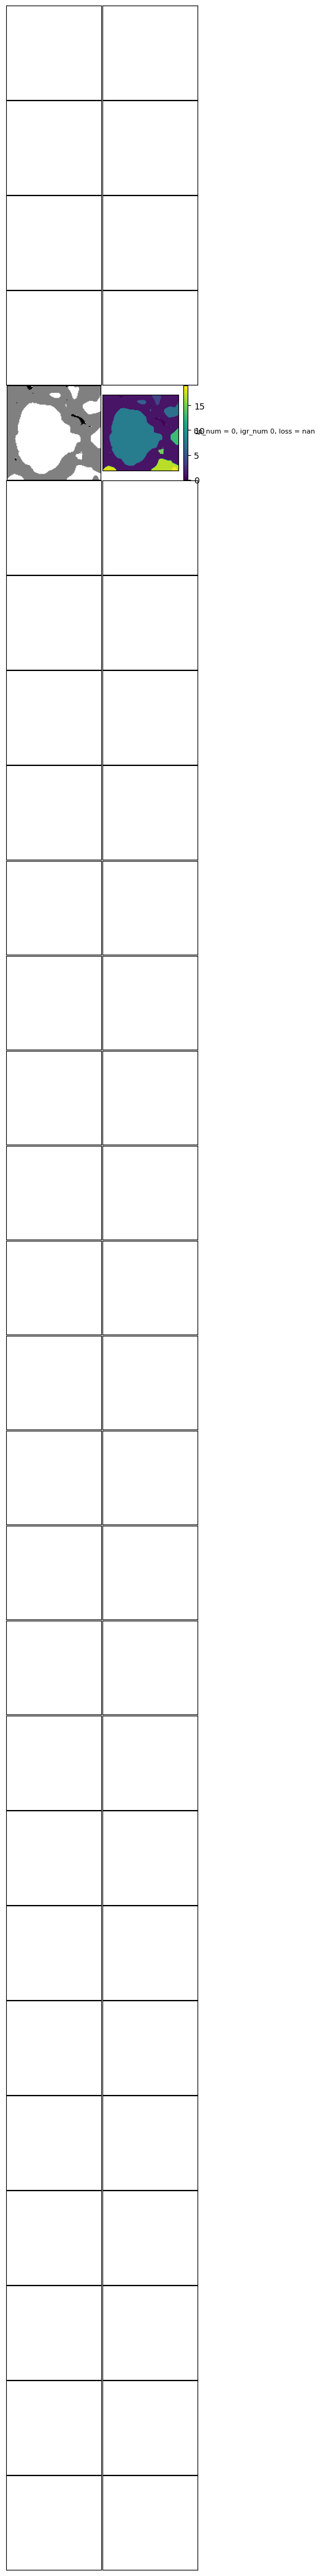

In [74]:
'''
"region size loss"
'''
importlib.reload(loss_funcs)
examples = pickle.load(open('example_segmentations.pkl','rb'))
fig, axs = plt.subplots(len(examples), 2, figsize=(2*2, 2*len(examples)))
for i in [4]: #range(len(examples)):
    pred = examples[i]
    seg = np.argmax(pred, axis=0) # dont need to actually convert to 0, 1.5, 2 # eval_utils.onehot_to_map(pred)
    axs[i,0].imshow(seg, cmap='gist_gray')
    regions = skimage.measure.label(seg)
    labels = np.unique(regions)
    im = axs[i,1].imshow(regions); plt.colorbar(im, ax=axs[i,1])
    
    # N0 = np.sum(preds[:,0,:,:])
    # N1 = np.sum(preds[:,1,:,:])
    # N2 = np.sum(preds[:,2,:,:])

    # N_low = np.min([N0, N1, N2])# number in the smallest class
    # N_high = np.max([N0, N1, N2]) # number in the largest class
    # N_mid = [N for N in [N0, N1, N2] if N not in [N_low, N_high]][0]
    
    bp_num = np.argmin(np.sum(pred, axis=(1,2)))
    reg_sizes = [len(regions[regions == label].flatten()) for label in labels]
    reg_classes = [np.mean(seg[regions==label]) for label in labels] # mean should work, since all all pix same value in given region
    classes = np.unique(seg)
    reg_per_class = [len(np.where(np.array(reg_classes)==cl)[0])for cl in classes]
    print('regions ', labels)
    print(f'reg_sizes', reg_sizes)
    print('reg_classes ', reg_classes) # WTF - FOR WNETM_1E ONLY ONE REGION IS FOUND TO HAVE VALUE 0.0 IN THE SEG, BUT THERE SHOULD BE 2!!
    print('classes ', classes)
    print('reg_per_class ', reg_per_class)
    igr_num = classes[reg_per_class==np.min(reg_per_class)][0]
    gr_num = [n for n in classes if n not in [bp_num, igr_num]
    
    sizes_bp = []; sizes_igr = []; sizes_gr = []
    for i in range(len(labels)):
        mask = np.zeroes_like((128, 128))
        mask[regions==label] = 1
        if reg_classes[i] == bp_num:
              sizes_bp.append(mask)
        if reg_classes[i] == igr_num:
              regions_igr.append(mask)
        if reg_classes[i] == gr_num:
              regions_gr.append(mask)

    loss = 
    plt.text(1.2, 0.5, f'bp_num = {bp_num}, igr_num {igr_num}, loss = {np.round(loss,3)}', fontsize=8, transform=axs[i,1].transAxes)
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)

/tmp/ipykernel_3443014/2681456724.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


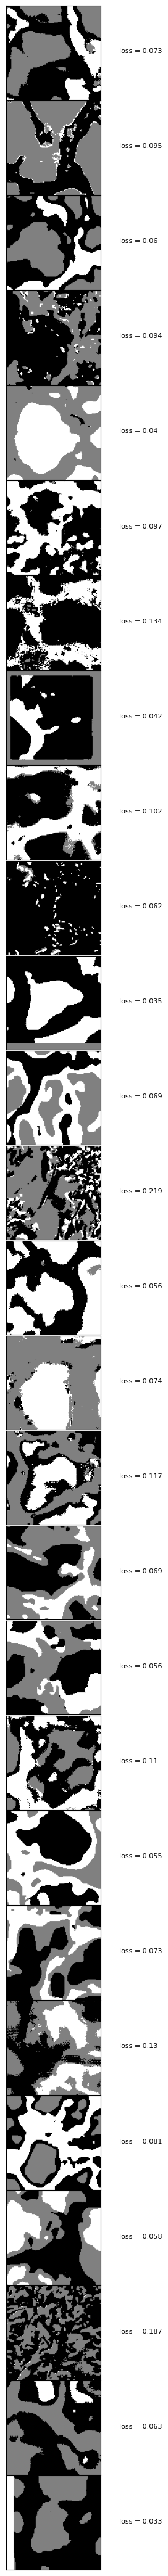

In [8]:
'''
"continuity loss" [from Guermazi 2024]
'''
examples = pickle.load(open('example_segmentations.pkl','rb'))
fig, axs = plt.subplots(len(examples), 1, figsize=(2*1, 2*len(examples)))
for i in range(len(examples)):
    pred = examples[i]
    axs[i].imshow(np.argmax(examples[i], axis=0), cmap='gist_gray')
    pred = torch.tensor(pred)
    #seg = np.argmax(pred, axis=0) # dont need to actually convert to 0, 1.5, 2 # eval_utils.onehot_to_map(pred)
    diff_h = torch.abs(pred[:, 1:, :] - pred[:, :-1, :]) #pred[:, :, 1:, :] - pred[:, :, :-1, :])
    diff_v = torch.abs(pred[:, :, 1:] - pred[:, :, :-1]) # pred[:, :, :, 1:] - pred[:, :, :, :-1])
    loss = torch.mean(diff_h) + torch.mean(diff_v)
    
    plt.text(1.2, 0.5, f'loss = {np.round(loss,3)}', fontsize=8, transform=axs[i].transAxes)
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)